In [1]:
import os
import sys
from collections import OrderedDict, defaultdict

import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec
from scipy import stats
from scipy.io import mmread, mmwrite
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize, scale

# from synchromesh.scripts.utils import read_str_list, sanitize_mtx, norm, do_pf, do_log_pf
# from synchromesh.scripts.plot import  plot_depth_norm, plot_depth_dist, plot_knee, plot_pc_depth, plot_mean_var, plot_monotone, plot_example_gene


def nd(arr):
    return np.asarray(arr).reshape(-1)


def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, "k-", alpha=0.75, zorder=0)
    ax.set_aspect("equal")
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax


fsize = 15

base_figure_path = "figures"


alpha = 0.33

import matplotlib

matplotlib.rcParams["mathtext.fontset"] = "cm"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams["font.size"] = fsize
%config InlineBackend.figure_format = 'retina'

In [2]:
cividis = matplotlib.cm.get_cmap("cividis")
colors = {"cell": cividis(0.01), "gene": cividis(0.5), "mono": cividis(0.99)}

In [3]:
mtx_labels = [
    "raw",
    "pf",
    "log",
    "pf_log",
    "pf_log_pf",
    "cpm_log",
    "cp10k_log",
    "sqrt",
    "sctransform_cc",
]
# labels = ['raw', 'pf', "sqrt", 'log', 'cp10k_log', 'cpm_log', 'cp10k_log_scale', 'sctransform', 'pf_log', 'pf_log_pf']
labels = [
    "raw",
    "PF",
    "sqrt",
    "log1p",
    "log1pCP10k",
    "log1pCPM",
    "scalelog1pCP10k",
    "sctransform",
    "log1pPF",
    "PFlog1pPF",
    "sctransform_cc",
]
txlabel = {
    "raw": "raw",
    "pf": "PF",
    "sqrt": "sqrt",
    "log": "log1p",
    "cp10k_log": "log1pCP10k",
    "cpm_log": "log1pCPM",
    "cp10k_log_scale": "scalelog1pCP10k",
    "sctransform": "sctransform",
    "pf_log": "log1pPF",
    "pf_log_pf": "PFlog1pPF",
    "sctransform_cc": "sctransform_cc",
}


def read_data(base_data_fn):
    data = {}

    for title in mtx_labels:
        print(f"loading {title}")
        in_fn = os.path.join(base_data_fn, f"{title}.mtx.gz")
        data[txlabel[title]] = mmread(in_fn).toarray()

    title = "sctransform"
    print(f"loading {title}")
    in_fn = os.path.join(base_data_fn, f"{title}.csv.gz")
    data[txlabel[title]] = pd.read_csv(in_fn, header=None).values

    title = "cp10k_log_scale"
    print(f"loading {title}")
    in_fn = os.path.join(base_data_fn, f"{title}.csv.gz")
    data[txlabel[title]] = pd.read_csv(in_fn, header=None).values
    return data

In [4]:
ds = "angelidis_2019"
out_prefix = os.path.join("synchromesh/data/", ds, "corrected_counts")

In [5]:
%%time
data = read_data(out_prefix)

loading raw
loading pf
loading log
loading pf_log
loading pf_log_pf
loading cpm_log
loading cp10k_log
loading sqrt
loading sctransform_cc
loading sctransform
loading cp10k_log_scale
CPU times: user 12min 17s, sys: 23.8 s, total: 12min 41s
Wall time: 12min 48s


In [6]:
bcs = pd.read_csv(
    os.path.join(out_prefix, "metadata_barcodes.txt.gz"),
    compression="gzip",
    index_col=0,
)
assignments = bcs.celltype.values

genes = pd.read_csv(
    os.path.join(out_prefix, "raw_genes.txt.gz"), compression="gzip", header=None
).values.ravel()

In [12]:
# cell types

celltypes = ["Type_2_pneumocytes", "Alveolar_macrophage", "Ciliated_cells"]
ct_masks = [assignments == i for i in celltypes]

In [13]:
ct = celltypes[0]
ct_mask = ct_masks[0]

In [14]:
ct

'Type_2_pneumocytes'

# Variance

## knee and mean var

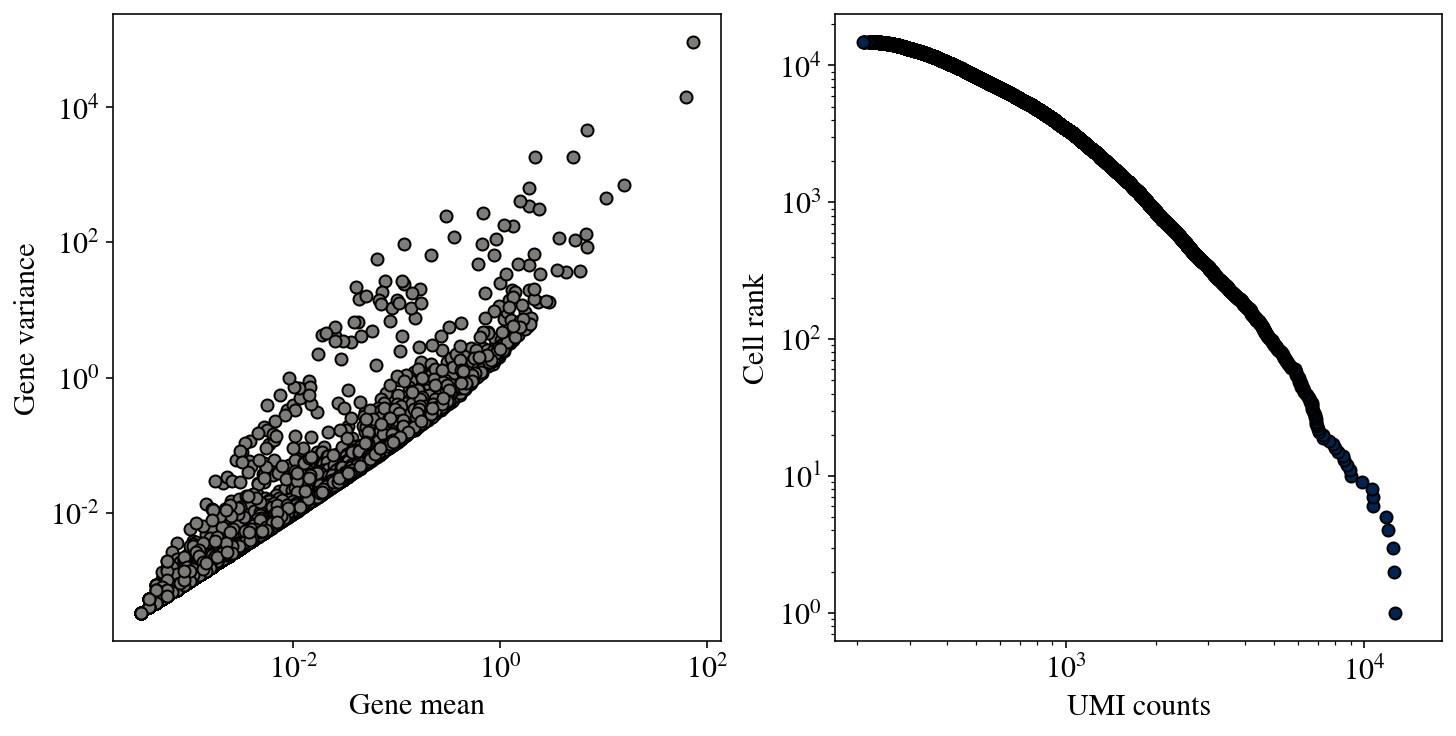

In [7]:
fig, axs = plt.subplots(figsize=(10, 5), ncols=2, constrained_layout=True)

ax = axs[0]

x = data["raw"].mean(0)
y = np.var(data["raw"], axis=0)

ax.scatter(x, y, facecolor=colors["gene"], edgecolor="k")

ax.set(
    **{
        "xlabel": "Gene mean",
        "ylabel": "Gene variance",
        "xscale": "log",
        "yscale": "log",
    }
)

ax = axs[1]

x = np.sort(data["raw"].sum(1))[::-1]
y = np.arange(x.shape[0])

ax.scatter(x, y, facecolor=colors["cell"], edgecolor="k")

ax.set(
    **{"xscale": "log", "yscale": "log", "xlabel": "UMI counts", "ylabel": "Cell rank"}
)

base_file_name = "angelidis_2019-knee_meanvar-scatter"
save_path = os.path.join(base_figure_path, base_file_name)
if not os.path.exists(save_path):
    os.makedirs(save_path)

fig.savefig(
    os.path.join(save_path, f"{base_file_name}.png"),
    facecolor="white",
    transparent=False,
    dpi=300,
    bbox_inches="tight",
)
fig.savefig(
    os.path.join(save_path, f"{base_file_name}.pdf"), dpi=300, bbox_inches="tight"
)

fig.show()

In [8]:
variances = {k: np.var(v, axis=0) for k, v in data.items()}

In [9]:
raw_genemean = data["raw"].mean(0)

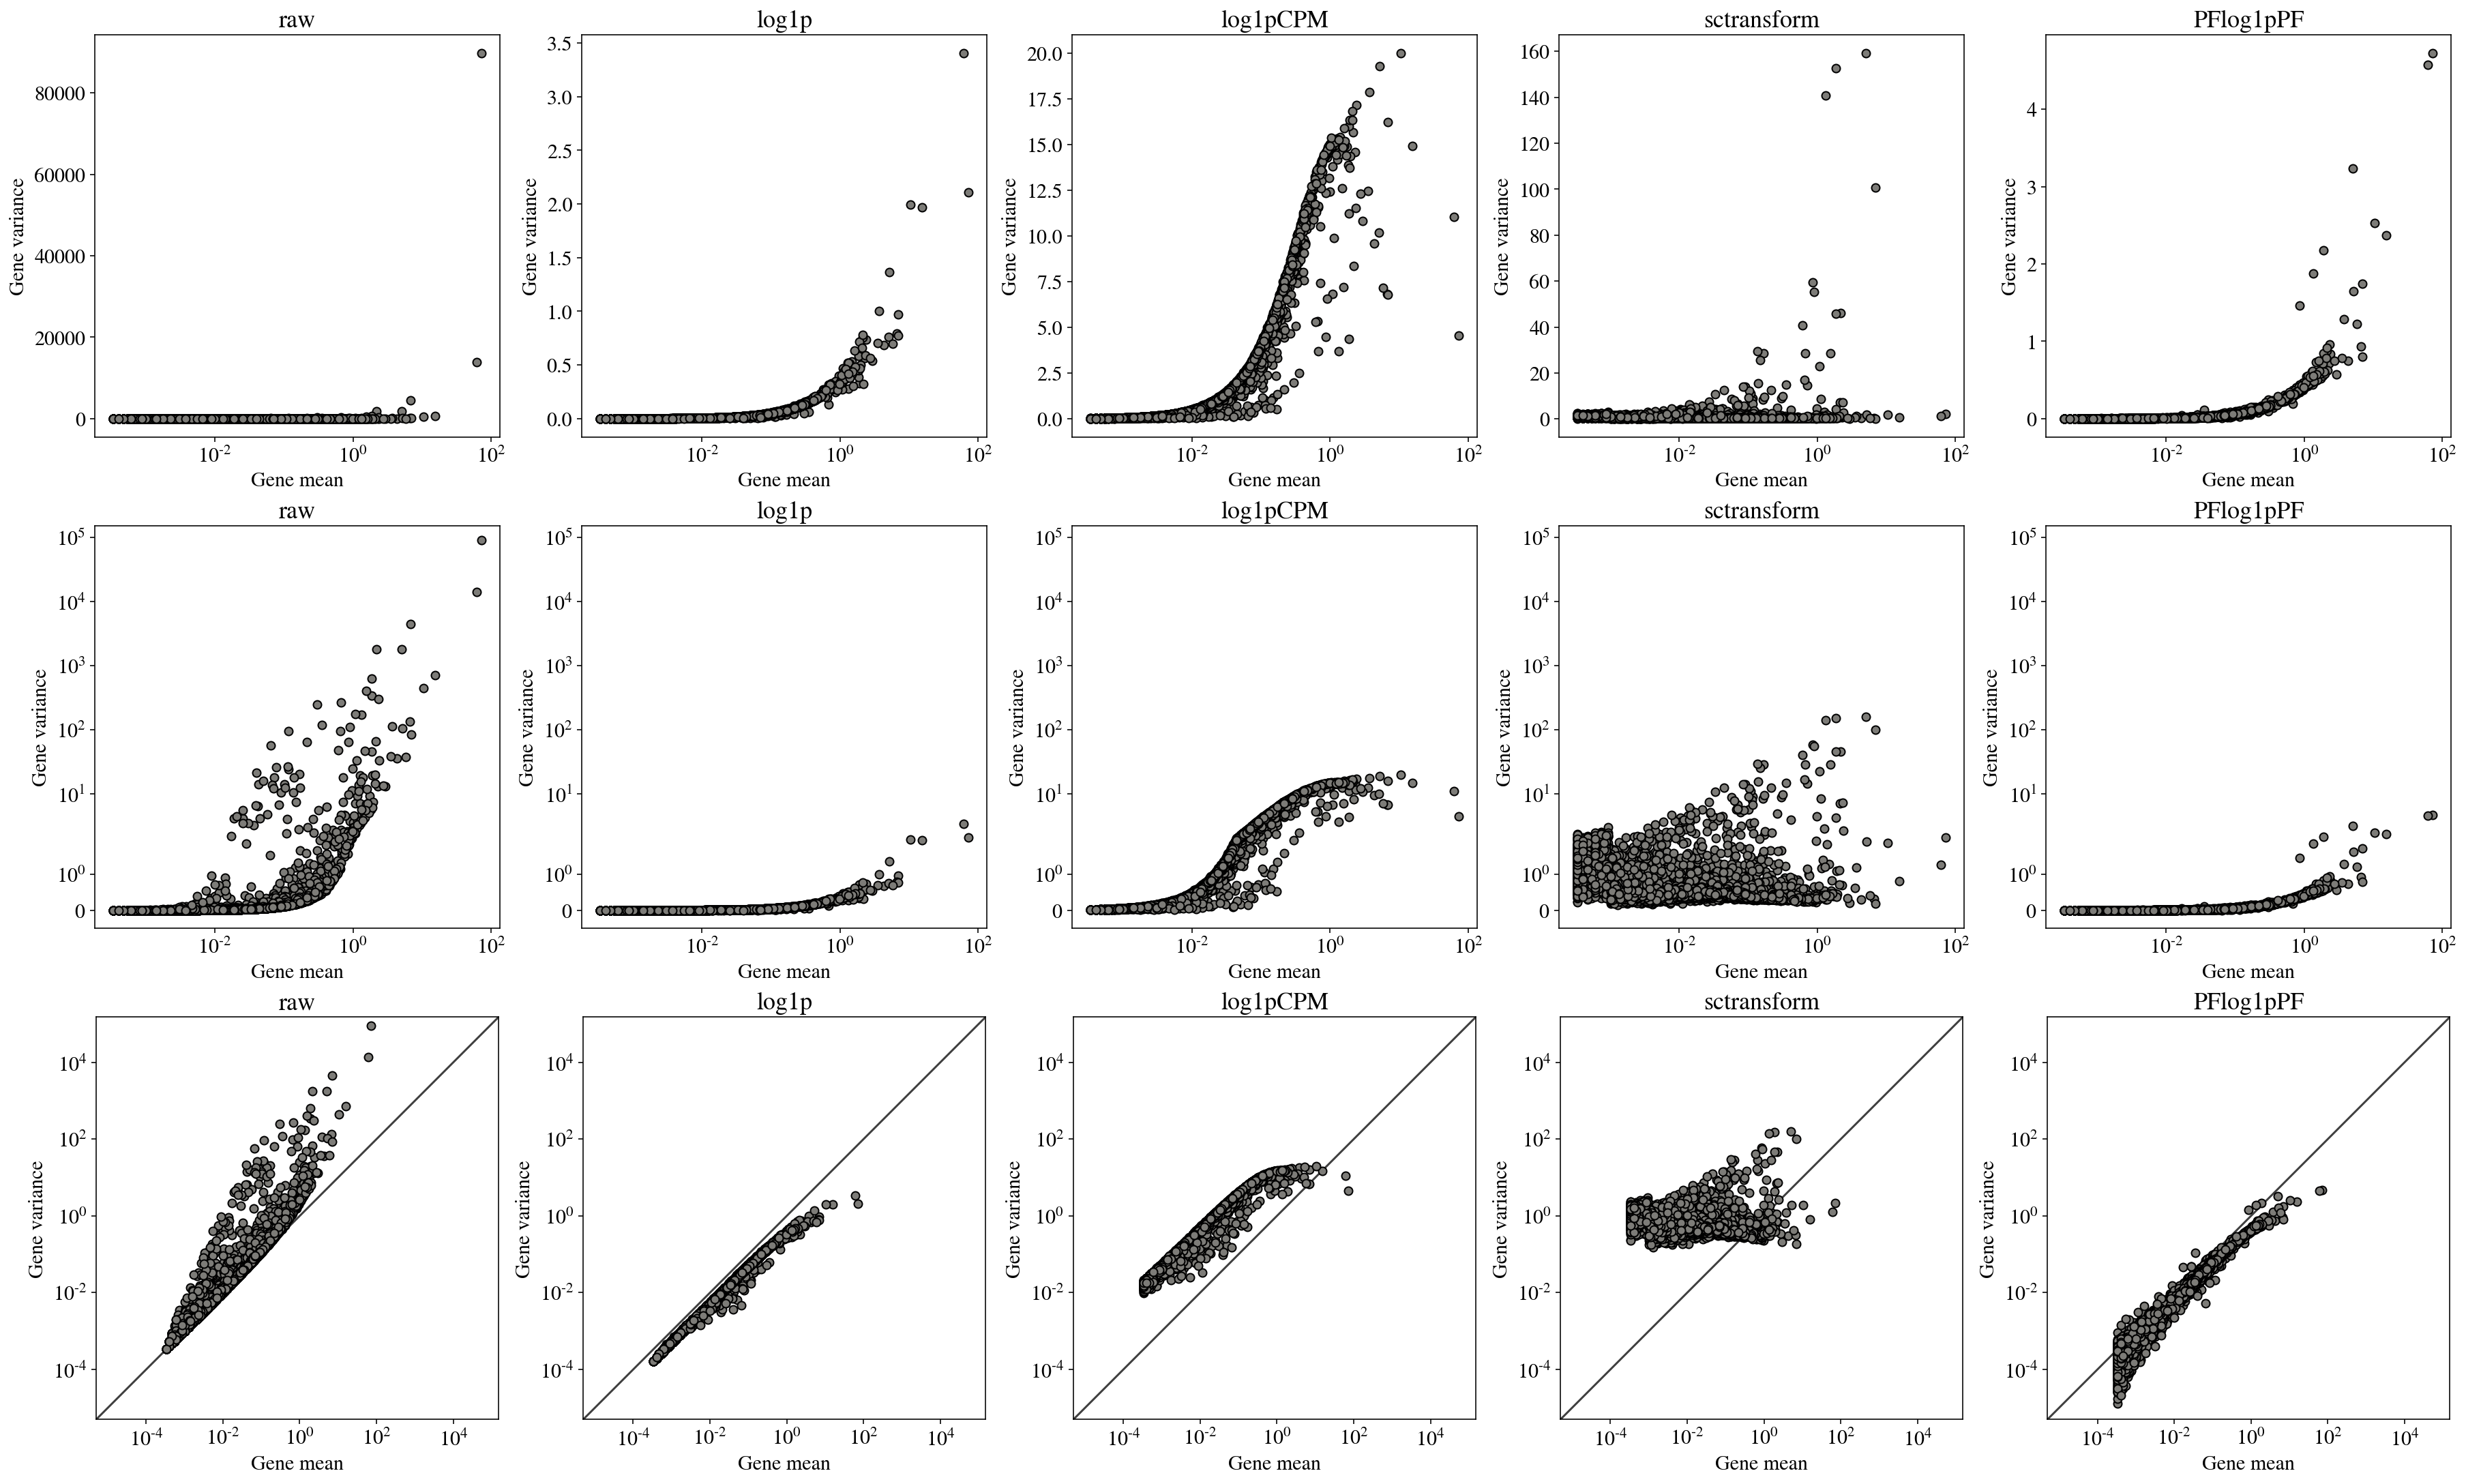

In [10]:
nc = 5
nr = 3

fig, axs = plt.subplots(
    figsize=(5 * nc, 5 * nr), ncols=nc, nrows=nr, constrained_layout=True
)

pltlabels = ["raw", "log1p", "log1pCPM", "sctransform", "PFlog1pPF"]

for idx, l in enumerate(pltlabels):
    ax = axs[0, idx]

    x = raw_genemean
    y = variances[l]

    ax.scatter(x, y, facecolor=colors["gene"], edgecolor="k")

    ax.set(
        **{
            "xlabel": "Gene mean",
            "ylabel": "Gene variance",
            "xscale": "log",
            "yscale": "linear",
            #         "ylim": (-1e4, 1.5e5),
            "title": l,
        }
    )

for idx, l in enumerate(pltlabels):
    ax = axs[1, idx]

    x = raw_genemean
    y = variances[l]

    ax.scatter(x, y, facecolor=colors["gene"], edgecolor="k")

    ax.set(
        **{
            "xlabel": "Gene mean",
            "ylabel": "Gene variance",
            "xscale": "log",
            "yscale": "symlog",
            "ylim": (-0.5, 1.5e5),
            "title": l,
        }
    )

for idx, l in enumerate(pltlabels):
    ax = axs[2, idx]

    x = raw_genemean
    y = variances[l]

    ax.scatter(x, y, facecolor=colors["gene"], edgecolor="k")

    ax.set(
        **{
            "xlabel": "Gene mean",
            "ylabel": "Gene variance",
            "xscale": "log",
            "yscale": "log",
            "ylim": (5e-6, 1.5e5),
            "title": l,
        }
    )
    yex(ax)


base_file_name = "angelidis_2019-meanvar_plot_styles-scatter"
save_path = os.path.join(base_figure_path, base_file_name)
if not os.path.exists(save_path):
    os.makedirs(save_path)

fig.savefig(
    os.path.join(save_path, f"{base_file_name}.png"),
    facecolor="white",
    transparent=False,
    dpi=300,
    bbox_inches="tight",
)
fig.savefig(
    os.path.join(save_path, f"{base_file_name}.pdf"), dpi=300, bbox_inches="tight"
)

fig.show()

# PC variance

In [15]:
%%time
# ## data for pc
pc_comps = {}
pc_fit = {}
for title, matrix in data.items():
    print(title)
    pca = PCA(n_components=1, svd_solver="full")
    Y = pca.fit_transform(matrix[ct_mask])
    pc_comps[title] = pca.components_
    pc_fit[title] = Y

raw
PF
log1p
log1pPF
PFlog1pPF
log1pCPM
log1pCP10k
sqrt
sctransform_cc
sctransform
scalelog1pCP10k
CPU times: user 4h 49min 29s, sys: 1h 17min 3s, total: 6h 6min 33s
Wall time: 8min 16s


In [16]:
ct_mask.sum()

4199

In [18]:
ct_metrics = defaultdict(dict)

In [19]:
pc_norm = defaultdict()

for idx, l in enumerate(labels):
    # magnitude of pc
    pc = np.abs(pc_comps[l])  # gene loadings

    # normalize between zero and one
    pcn = normalize(pc, norm="l1")[0]

    # compute the entropy
    ent = stats.entropy(pcn)

    print(f"{l}\t{ent}")
    # save norm vector
    pc_norm[l] = pcn

    # save entropy to ct_metrics
    ct_metrics[l]["pc_entropy"] = ent

raw	5.976929973592573
PF	5.3669956608835845
sqrt	8.360781912110472
log1p	8.42779545156364
log1pCP10k	8.583779951129223
log1pCPM	8.683813337301101
scalelog1pCP10k	9.168871956866903
sctransform	9.316958262806056
log1pPF	8.236090687865959
PFlog1pPF	8.163219894497587
sctransform_cc	5.030139566863156


/home/sina/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


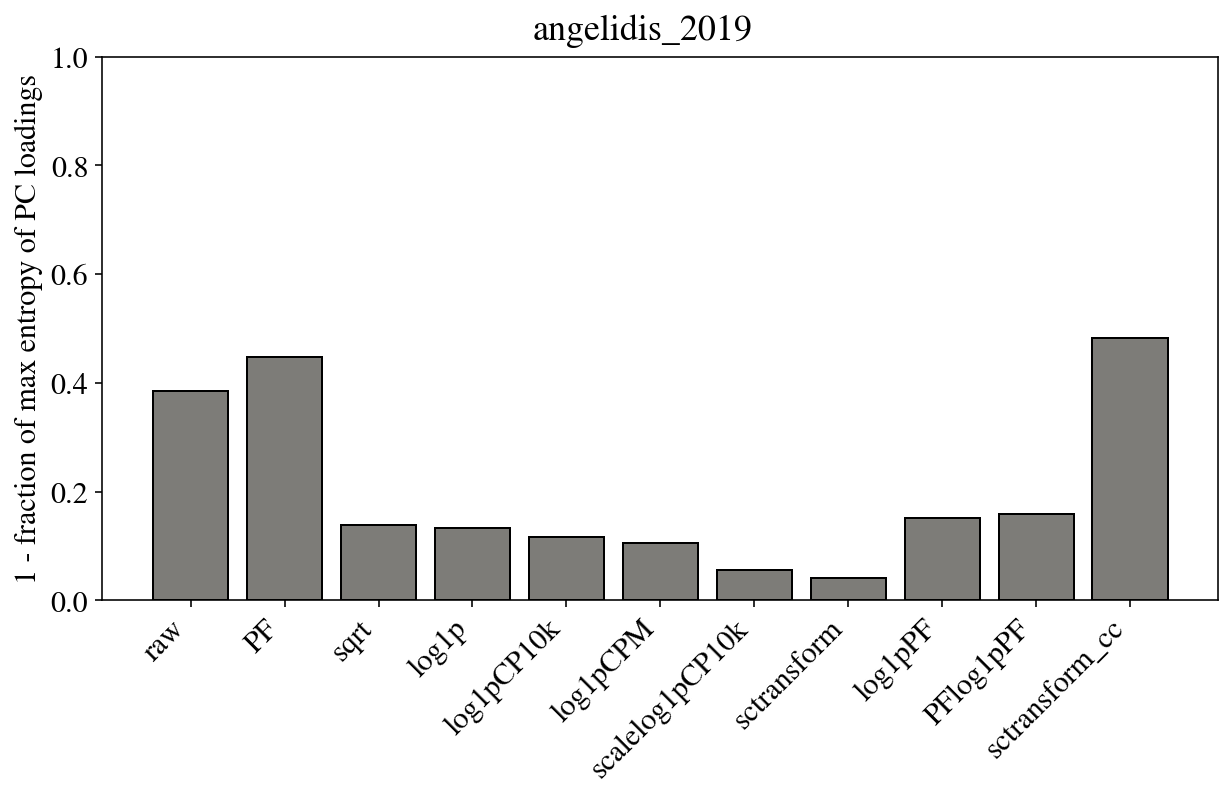

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle(ds, y=0.94)
x = labels
y = [ct_metrics[i]["pc_entropy"] for i in x]
max_ent = np.log(len(genes))
ax.bar(x, (max_ent - y) / max_ent, facecolor=colors["gene"], edgecolor="k")
ax.set(**{"ylabel": "1 - fraction of max entropy of PC loadings", "ylim": (0, 1)})

ax.set_xticklabels(x, ha="right", rotation=45)

fig.savefig(
    f"{ds}_pc_entropy.png",
    facecolor="white",
    transparent=False,
    dpi=300,
    bbox_inches="tight",
)

base_file_name = "angelidis_2019-pc_entropy-bar"
save_path = os.path.join(base_figure_path, base_file_name)
if not os.path.exists(save_path):
    os.makedirs(save_path)

fig.savefig(
    os.path.join(save_path, f"{base_file_name}.png"),
    facecolor="white",
    transparent=False,
    dpi=300,
    bbox_inches="tight",
)
fig.savefig(
    os.path.join(save_path, f"{base_file_name}.pdf"), dpi=300, bbox_inches="tight"
)

fig.show()

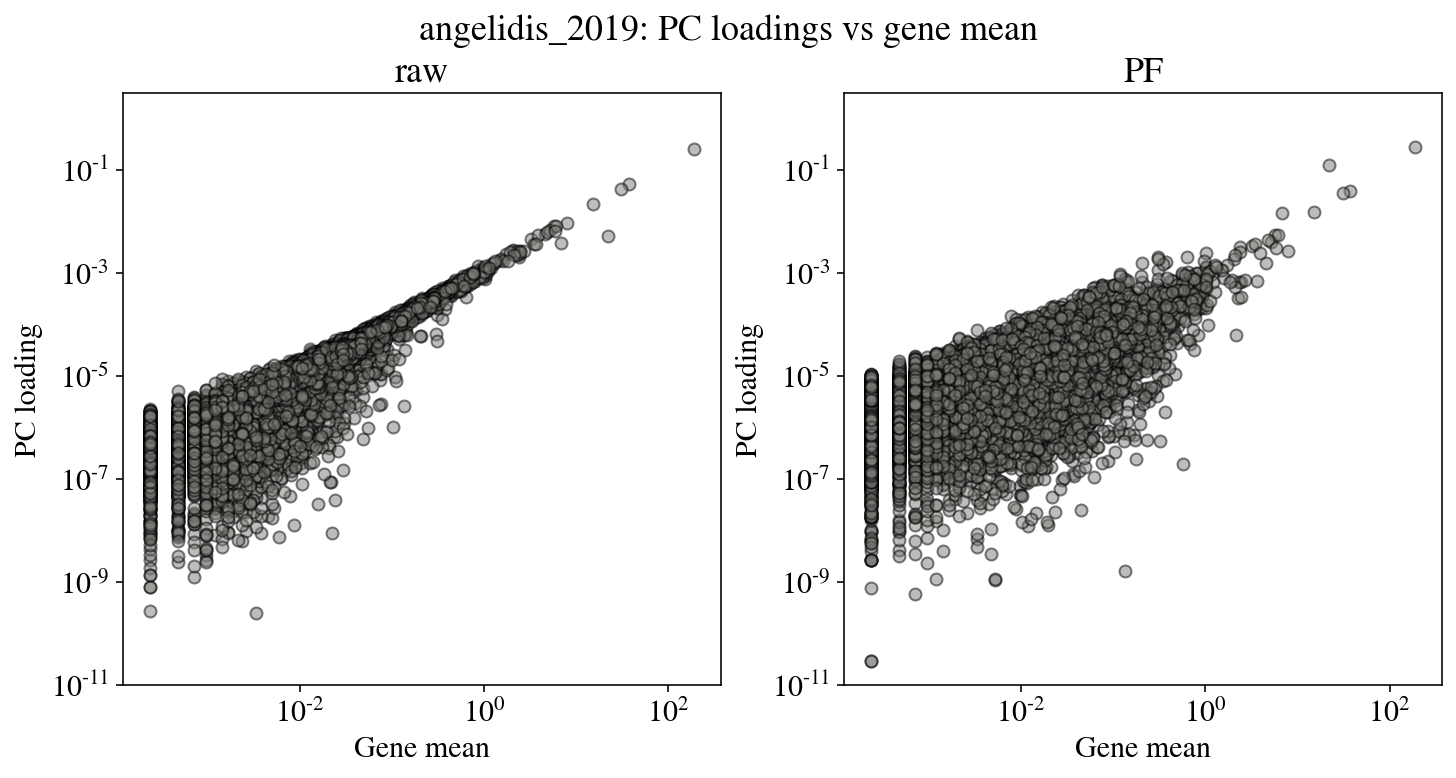

In [24]:
fig, axs = plt.subplots(figsize=(10, 5), ncols=2, constrained_layout=True)
fig.suptitle(f"{ds}: PC loadings vs gene mean", y=1.05)
ax = axs[0]

x = np.mean(data["raw"][ct_mask], 0)
y = pc_norm["raw"]


ax.scatter(x, y, alpha=0.5, facecolor=colors["gene"], edgecolor="k")
ax.set(
    **{
        "xscale": "log",
        "yscale": "log",
        "ylim": (1e-11),
        "xlabel": "Gene mean",
        "ylabel": "PC loading",
        "title": "raw",
    }
)

ax = axs[1]
# todo add pf to this one
x = np.mean(data["raw"][ct_mask], 0)
y = pc_norm["PF"]

ax.scatter(x, y, alpha=0.5, facecolor=colors["gene"], edgecolor="k")
ax.set(
    **{
        "xscale": "log",
        "yscale": "log",
        "ylim": (1e-11),
        "xlabel": "Gene mean",
        "ylabel": "PC loading",
        "title": "PF",
    }
)

base_file_name = "angelidis_2019-pc_raw_loadings_gene_mean-scatter"
save_path = os.path.join(base_figure_path, base_file_name)
if not os.path.exists(save_path):
    os.makedirs(save_path)

fig.savefig(
    os.path.join(save_path, f"{base_file_name}.png"),
    facecolor="white",
    transparent=False,
    dpi=300,
    bbox_inches="tight",
)
fig.savefig(
    os.path.join(save_path, f"{base_file_name}.pdf"), dpi=300, bbox_inches="tight"
)

fig.show()

In [22]:
ct_metrics

defaultdict(dict,
            {'raw': {'pc_entropy': 5.976929973592573},
             'PF': {'pc_entropy': 5.3669956608835845},
             'sqrt': {'pc_entropy': 8.360781912110472},
             'log1p': {'pc_entropy': 8.42779545156364},
             'log1pCP10k': {'pc_entropy': 8.583779951129223},
             'log1pCPM': {'pc_entropy': 8.683813337301101},
             'scalelog1pCP10k': {'pc_entropy': 9.168871956866903},
             'sctransform': {'pc_entropy': 9.316958262806056},
             'log1pPF': {'pc_entropy': 8.236090687865959},
             'PFlog1pPF': {'pc_entropy': 8.163219894497587},
             'sctransform_cc': {'pc_entropy': 5.030139566863156}})